# NN w/ GA to Learn Freq of New Residuals

## Setup Dataset

In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

#
# Define Training Dataset
#
n_samples = 600
x1 = np.linspace(start=0, stop=2*np.pi, num=n_samples)
f_1 = 2 # Hz
f_1_array = np.full((n_samples,), f_1) 
f_2 = 3.5 # Hz
f_2_array = np.full((n_samples,), f_2) 
f_3 = 5 # Hz
f_3_array = np.full((n_samples,), f_3) 

# Used sines to define residuals since it is an extreme test case (i.e if the model can handle a sine, it should handle other waveforms)
g_1 = np.sin(2 * np.pi * f_1 * x1) 
g_2 = np.sin(2 * np.pi * f_2 * x1) 
g_3 = np.sin(2 * np.pi * f_3 * x1) 

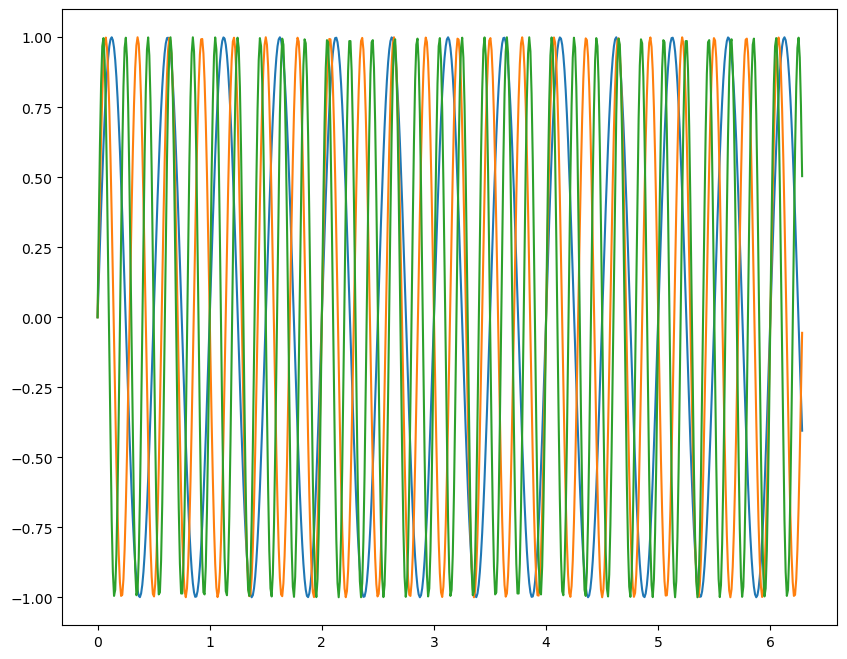

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(x1, g_1, label='f_1')
plt.plot(x1, g_2, label='f_2')
plt.plot(x1, g_3, label='f_3')
plt.show()

In [23]:
# Stack the features and targets vertically
x_train = np.vstack([np.column_stack((x1, f_1_array)),
                     np.column_stack((x1, f_2_array)),
                     np.column_stack((x1, f_3_array))
                     ])
y_train = np.concatenate([g_1, g_2, g_3], axis=0).reshape(-1, 1)


#
# Define Test Dataset
#
f_4 = f_1 # Hz
f_4_array = np.full((n_samples,), f_4) # Hz
g_4 = np.sin(2 * np.pi * f_4 * x1)

x_test = np.column_stack((x1, f_4_array))
y_test = g_4.reshape(-1, 1)

In [24]:
x_test

array([[0.        , 2.        ],
       [0.01048946, 2.        ],
       [0.02097892, 2.        ],
       ...,
       [6.26220639, 2.        ],
       [6.27269585, 2.        ],
       [6.28318531, 2.        ]])

In [25]:
y_test

array([[ 0.00000000e+00],
       [ 1.31433034e-01],
       [ 2.60585718e-01],
       [ 3.85217267e-01],
       [ 5.03165337e-01],
       [ 6.12383539e-01],
       [ 7.10976949e-01],
       [ 7.97234983e-01],
       [ 8.69661072e-01],
       [ 9.26998631e-01],
       [ 9.68252858e-01],
       [ 9.92707999e-01],
       [ 9.99939757e-01],
       [ 9.89822664e-01],
       [ 9.62532249e-01],
       [ 9.18541998e-01],
       [ 8.58615138e-01],
       [ 7.83791394e-01],
       [ 6.95368950e-01],
       [ 5.94881926e-01],
       [ 4.84073762e-01],
       [ 3.64866968e-01],
       [ 2.39329769e-01],
       [ 1.09640224e-01],
       [-2.19515680e-02],
       [-1.53162503e-01],
       [-2.81716084e-01],
       [-4.05381919e-01],
       [-5.22014421e-01],
       [-6.29590025e-01],
       [-7.26242308e-01],
       [-8.10294361e-01],
       [-8.80287890e-01],
       [-9.35008515e-01],
       [-9.73506839e-01],
       [-9.95114918e-01],
       [-9.99457857e-01],
       [-9.86460304e-01],
       [-9.5

In [26]:
x_train

array([[0.        , 2.        ],
       [0.01048946, 2.        ],
       [0.02097892, 2.        ],
       ...,
       [6.26220639, 5.        ],
       [6.27269585, 5.        ],
       [6.28318531, 5.        ]])

In [27]:
y_train

array([[0.        ],
       [0.13143303],
       [0.26058572],
       ...,
       [0.92737005],
       [0.75639568],
       [0.50402193]])

In [28]:
# Transform data for NN
scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler1.fit_transform(x_train) # fit scaler1 based on input training set
x_test_scaled = scaler1.transform(x_test)
y_train_scaled = scaler2.fit_transform(y_train) # fit scaler2 based on output training set
y_test_scaled = scaler2.transform(y_test)

## Setup Model

In [29]:
import os
import matplotlib.pyplot as plt
import pygad
from torch import nn, optim
import copy
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = torch.device(device)
input_size = 2
hidden_size = 128
output_size = 1
num_epochs = 100
learning_rate = 0.001
train_running_loss = 0
test_running_loss = 0
test_loss = []

# Setup model. And define loss and optimizer
model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size // 2),
                      nn.ReLU(),
                      nn.Linear(hidden_size // 2, hidden_size // 4),
                      nn.ReLU(),
                      nn.Linear(hidden_size // 4, output_size)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [30]:
# Keep the best model
best_rmse = np.inf 
best_epoch = -1
best_weights = None

# Convert SCALED values to tensors
x_train_tens = torch.tensor(x_train_scaled, dtype=torch.float32, requires_grad=False).to(device)
x_test_tens = torch.tensor(x_test_scaled, dtype=torch.float32, requires_grad=False).to(device)
y_train_tens = torch.tensor(y_train_scaled, dtype=torch.float32, requires_grad=False).to(device)
y_test_tens = torch.tensor(y_test_scaled, dtype=torch.float32, requires_grad=False).to(device)

# # Convert UNSCALED values to tensors
# x_train_tens = torch.tensor(x_train, dtype=torch.float32, requires_grad=False).to(device)
# x_test_tens = torch.tensor(x_test, dtype=torch.float32, requires_grad=False).to(device)
# y_train_tens = torch.tensor(y_train, dtype=torch.float32, requires_grad=False).to(device)
# y_test_tens = torch.tensor(y_test, dtype=torch.float32, requires_grad=False).to(device)

# Train model
for epoch in range(num_epochs):
    model.train()
    for batchid, x in enumerate(x_train_tens):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = torch.sqrt(criterion(y_pred, y_train_tens[batchid, :]))  # NOTE: SCALED RMSE

        loss.backward()
        optimizer.step()
        # train_running_loss += loss.item()

    # Test model with gradient updates off
    model.eval()
    with torch.no_grad():
        y_test_pred = model(x_test_tens)
        # loss_unscaled = float(torch.sqrt(criterion(torch.tensor(
        #     scaler2.inverse_transform(y_test_pred.detach().cpu().numpy())),
        #               torch.tensor(y_test))))  # RMSE; UNSCALED
        
        loss_unscaled = float(torch.sqrt(criterion(y_test_pred, y_test_tens)))  # RMSE; UNSCALED
        # test_running_loss += loss_unscaled
        test_loss.append(loss_unscaled)
        print('Iter %d/%d - Loss Unscaled: %.5f' % (epoch + 1, num_epochs, loss_unscaled))
        if loss_unscaled < best_rmse:
            best_epoch = epoch
            best_rmse = loss_unscaled
            best_weights = copy.deepcopy(model.state_dict())

print(f"Best Epoch: {best_epoch}, Best Test RMSE: {best_rmse} (unscaled error)")

Iter 1/100 - Loss Unscaled: 0.70498
Iter 2/100 - Loss Unscaled: 0.70497
Iter 3/100 - Loss Unscaled: 0.70494
Iter 4/100 - Loss Unscaled: 0.70493
Iter 5/100 - Loss Unscaled: 0.70493
Iter 6/100 - Loss Unscaled: 0.70493
Iter 7/100 - Loss Unscaled: 0.70495
Iter 8/100 - Loss Unscaled: 0.70493
Iter 9/100 - Loss Unscaled: 0.70493
Iter 10/100 - Loss Unscaled: 0.70493
Iter 11/100 - Loss Unscaled: 0.70493
Iter 12/100 - Loss Unscaled: 0.70493
Iter 13/100 - Loss Unscaled: 0.70493
Iter 14/100 - Loss Unscaled: 0.70495
Iter 15/100 - Loss Unscaled: 0.70493
Iter 16/100 - Loss Unscaled: 0.70493
Iter 17/100 - Loss Unscaled: 0.70493
Iter 18/100 - Loss Unscaled: 0.70493
Iter 19/100 - Loss Unscaled: 0.70493
Iter 20/100 - Loss Unscaled: 0.70493
Iter 21/100 - Loss Unscaled: 0.70493
Iter 22/100 - Loss Unscaled: 0.70493
Iter 23/100 - Loss Unscaled: 0.70493
Iter 24/100 - Loss Unscaled: 0.70493
Iter 25/100 - Loss Unscaled: 0.70493
Iter 26/100 - Loss Unscaled: 0.70494
Iter 27/100 - Loss Unscaled: 0.70493
Iter 28/10

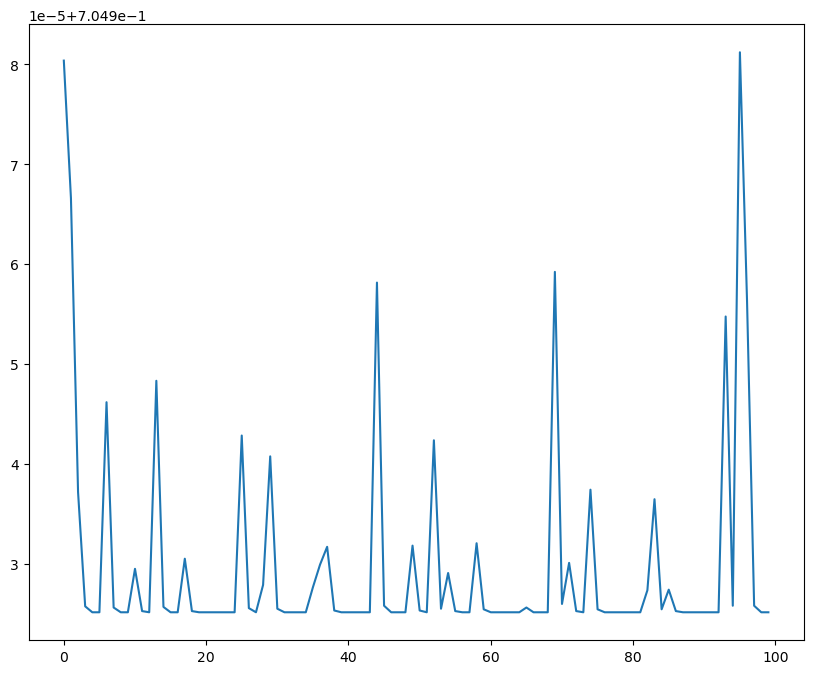

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(test_loss)
plt.show()

In [32]:
# # Load the best model and put in eval mode
# model.load_state_dict(best_weights)
# model.eval()

## Sanity Check: Input x1 using a previously seen f_4 during training 

In [33]:
# NOTE: Only a sanity check if using f_4 equal to one of the f_x used during training
y_check = model(x_test_tens)
y_check_unscaled = scaler2.inverse_transform(y_check.detach().cpu().numpy())

In [34]:
print(y_check_unscaled)

[[0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00121321]
 [0.00

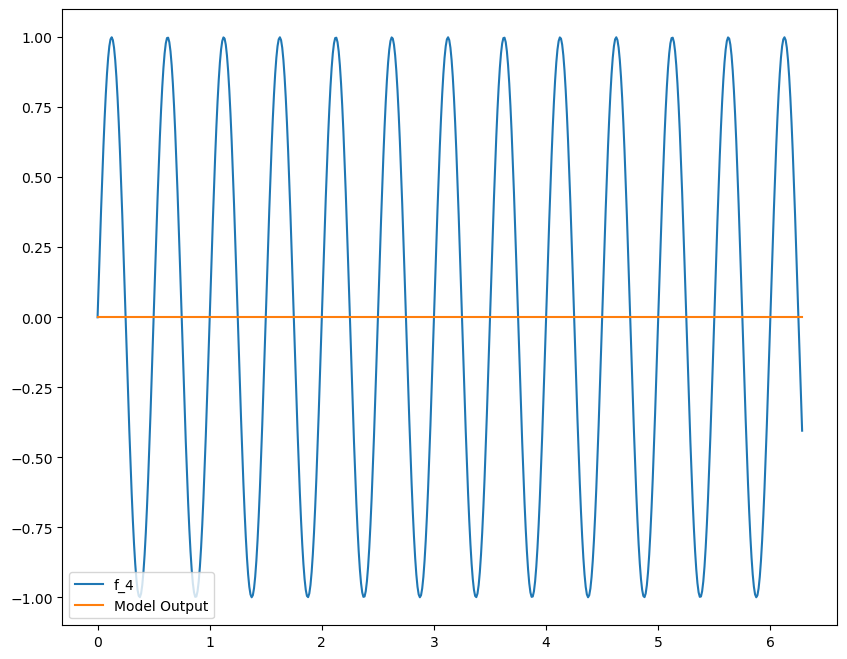

In [35]:
plt.figure(figsize=(10, 8))
plt.plot(x1, g_4, label='f_4')
plt.plot(x1, y_check_unscaled, label='Model Output')
plt.legend()
plt.show()

## Setup Genetic Algo w/ Pretrained Model in Fitness Function

In [36]:
x_test

array([[0.        , 2.        ],
       [0.01048946, 2.        ],
       [0.02097892, 2.        ],
       ...,
       [6.26220639, 2.        ],
       [6.27269585, 2.        ],
       [6.28318531, 2.        ]])

In [37]:
g_4.reshape(-1, 1)

array([[ 0.00000000e+00],
       [ 1.31433034e-01],
       [ 2.60585718e-01],
       [ 3.85217267e-01],
       [ 5.03165337e-01],
       [ 6.12383539e-01],
       [ 7.10976949e-01],
       [ 7.97234983e-01],
       [ 8.69661072e-01],
       [ 9.26998631e-01],
       [ 9.68252858e-01],
       [ 9.92707999e-01],
       [ 9.99939757e-01],
       [ 9.89822664e-01],
       [ 9.62532249e-01],
       [ 9.18541998e-01],
       [ 8.58615138e-01],
       [ 7.83791394e-01],
       [ 6.95368950e-01],
       [ 5.94881926e-01],
       [ 4.84073762e-01],
       [ 3.64866968e-01],
       [ 2.39329769e-01],
       [ 1.09640224e-01],
       [-2.19515680e-02],
       [-1.53162503e-01],
       [-2.81716084e-01],
       [-4.05381919e-01],
       [-5.22014421e-01],
       [-6.29590025e-01],
       [-7.26242308e-01],
       [-8.10294361e-01],
       [-8.80287890e-01],
       [-9.35008515e-01],
       [-9.73506839e-01],
       [-9.95114918e-01],
       [-9.99457857e-01],
       [-9.86460304e-01],
       [-9.5

In [367]:
# Define the desired target output
sample_number = 20 # Pick a row number from the above arrays to use for x1 and target output

input_scaled = scaler1.transform(x_test[sample_number, :].reshape(1, 2)) # NOTE: Have to provide 2 values to the scaler, so used entire row
x1_known = torch.tensor(input_scaled[0, 0], # Extract x1 value from input_scaled
                        dtype=torch.float32, 
                        requires_grad=False).to(device)
target_output = np.array(g_4[sample_number]).reshape(-1, 1)
target_output_scaled = scaler2.transform(target_output)
target_output_tens = torch.tensor(target_output_scaled,
                                  dtype=torch.float32,
                                  requires_grad=False).to(device)

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    """
    Fitness function to minimize the RMSE between the model's output and the target output.
    
    Returns: Negative RMSE (since PyGAD maximizes the fitness and we want to minimize RMSE).
    """
    
    # NOTE: solution should be a SCALED representation of f_4 
    solution_tensor = torch.tensor(solution, dtype=torch.float32, requires_grad=False).to(device)
    print(solution_tensor)
    
    # Combine x1_known with solution (f_4 prediction) to create the full input tensor
    input_tensor = torch.cat((x1_known.view(1), solution_tensor), dim=0).to(device)
    
    predicted_output = model(input_tensor)
    loss = torch.sqrt(criterion(predicted_output, target_output_tens))  # RMSE Loss

    # Return negative loss as PyGAD maximizes the fitness score
    return -loss.item()


# Parameters for PyGAD
population_size = 150
num_generations = 300

# Initialize PyGAD with only the unknown inputs as genes
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=population_size,
    num_genes=input_size - 1, # NOTE: Exclude x1_known, only use f_x as a gene
    mutation_percent_genes=10,
    mutation_type="random",
    crossover_type="single_point",
    init_range_low=-2, # NOTE: f_4 could be less than f_x used in fitting scaler1
    init_range_high=2, # NOTE: f_4 could be greater than f_x used in fitting scaler1
    parent_selection_type="sss",
    crossover_probability=0.4,
    mutation_probability=0.1
)

/Users/lancepharand/ENTER/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


## Run GA and Plot the Fitness Function

tensor([-1.9235], device='mps:0')
tensor([1.2752], device='mps:0')
tensor([-0.5313], device='mps:0')
tensor([-1.5350], device='mps:0')
tensor([0.2895], device='mps:0')
tensor([0.3570], device='mps:0')
tensor([-1.3487], device='mps:0')
tensor([0.2476], device='mps:0')
tensor([-1.2515], device='mps:0')
tensor([0.7110], device='mps:0')
tensor([0.5320], device='mps:0')
tensor([1.2394], device='mps:0')
tensor([1.6477], device='mps:0')
tensor([0.5030], device='mps:0')
tensor([1.1792], device='mps:0')
tensor([-1.8660], device='mps:0')
tensor([-0.6613], device='mps:0')
tensor([-1.0301], device='mps:0')
tensor([1.0976], device='mps:0')
tensor([1.3371], device='mps:0')
tensor([-0.4956], device='mps:0')
tensor([-0.7376], device='mps:0')
tensor([-0.0992], device='mps:0')
tensor([1.2418], device='mps:0')
tensor([-1.9634], device='mps:0')
tensor([-0.0822], device='mps:0')
tensor([-0.7219], device='mps:0')
tensor([-1.6955], device='mps:0')
tensor([-0.0778], device='mps:0')
tensor([-0.8372], device='m

/Users/lancepharand/ENTER/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([1.0884], device='mps:0')
tensor([-0.5466], device='mps:0')
tensor([1.1136], device='mps:0')
tensor([0.3840], device='mps:0')
tensor([-0.6249], device='mps:0')
tensor([-1.2454], device='mps:0')
tensor([-0.8384], device='mps:0')
tensor([1.7109], device='mps:0')
tensor([-0.8486], device='mps:0')
tensor([0.2411], device='mps:0')
tensor([0.5437], device='mps:0')
tensor([-1.8555], device='mps:0')
tensor([1.1774], device='mps:0')
tensor([-0.5683], device='mps:0')
tensor([1.8928], device='mps:0')
tensor([0.9022], device='mps:0')
tensor([1.2671], device='mps:0')
tensor([-1.6142], device='mps:0')
tensor([-1.0025], device='mps:0')
tensor([-0.7204], device='mps:0')
tensor([1.8497], device='mps:0')
tensor([0.6547], device='mps:0')
tensor([-1.3279], device='mps:0')
tensor([-0.5324], device='mps:0')
tensor([0.2348], device='mps:0')
tensor([1.8747], device='mps:0')
tensor([0.2155], device='mps:0')
tensor([0.0726], device='mps:0')
tensor([1.6776], device='mps:0')
tensor([-1.9094], device='mps:0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([-2.4694], device='mps:0')
tensor([-1.7816], device='mps:0')
tensor([-2.5273], device='mps:0')
tensor([-2.4171], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.6373], device='mps:0')
tensor([-2.1964], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.6444], device='mps:0')
tensor([-1.5574], device='mps:0')
tensor([-1.4306], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-2.9408], device='mps:0')
tensor([-2.9383], device='mps:0')
tensor([-1.0463], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-2.3544], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.1972], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.0649], device='mps:0')
tensor([-1.9520], device='mps:0')
tensor([-2.0294], device='mps:0')
tensor([-1.064

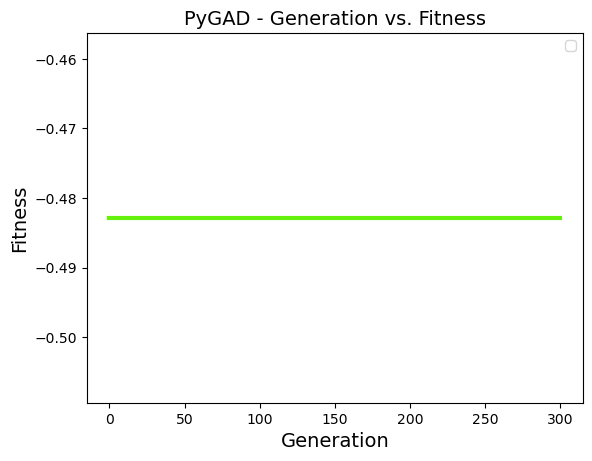

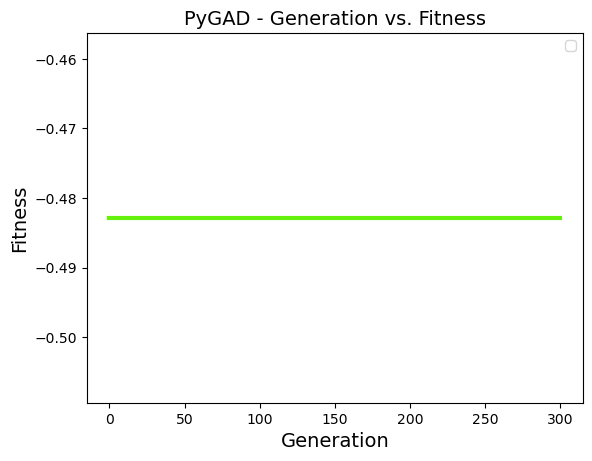

In [368]:
# Run GA
ga_instance.run()

# Get the best solution
best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

# Plot the fitness over generations
ga_instance.plot_fitness()

## Eval Model

In [369]:
# Convert best input to tensor and inverse scale it
optimized_input_tensor = torch.tensor(best_solution, dtype=torch.float32, requires_grad=False)
input_ga_scaled = np.array([x1_known.item(), optimized_input_tensor.cpu().numpy().squeeze()]).reshape(1, 2)
optimized_input = scaler1.inverse_transform(input_ga_scaled)

# Print the best input and its error (RMSE)
print(f"Model input: {optimized_input}")
print(f"Best solution f_4: {optimized_input[0, 1]} Hz")
print(f"Expected f_4: {f_4} Hz")
print(f"Best Fitness (negative RMSE): {best_solution_fitness}")

Model input: [[0.2097891  0.56838006]]
Best solution f_4: 0.5683800578117366 Hz
Expected f_4: 2 Hz
Best Fitness (negative RMSE): -0.48286059498786926
